## Initialization

In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Constants

In [ ]:
PROJECT_ROOT = 'absolute-path-of-project-root'
TRAIN_MBTR_DIR = PROJECT_ROOT + "/data/processed/training_set/features"
TEST_MBTR_DIR = PROJECT_ROOT + "/data/processed/test_set/features"
TRAIN_SASA_DIR = PROJECT_ROOT + "/data/processed/training_set/label"
TEST_SASA_DIR = PROJECT_ROOT + "/data/processed/test_set/label"
MODELS_DIR = PROJECT_ROOT + "/models"
PLOTS_DIR = PROJECT_ROOT + "/plots"
WINDOW_SIZE = 30
SAVE_MODELS = False
RANDOM_STATE = 123

## Imports

In [ ]:
import numpy as np
import pandas as pd
import os
from joblib import dump, load
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import copy
import keras
from numpy.lib.stride_tricks import sliding_window_view
import random
from sklearn.model_selection import KFold
import pickle
import re
import matplotlib.pyplot as plt

# models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

## Helper Functions

In [ ]:
def evaluate_results(y, y_hat, return_values = False, show_outputs = True):
  if len(y.shape) > 2:
    y = y.reshape((y.shape[0], -1))
    y_hat = y_hat.reshape((y_hat.shape[0], -1))
  mae = mean_absolute_error(y, y_hat)
  mse = mean_squared_error(y, y_hat)
  rmse = mean_squared_error(y, y_hat, squared=False)
  if show_outputs:
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
  if return_values:
    return mae, mse, rmse

In [ ]:
def load_model(model_name, num_feature, directory):
    """
    Loads the sepcified model and returns the object representing that model.

    This function is a utility function that loads any of the models used in
    this project. The function reads the model from the specified directory
    through methods applicable to the type of model.

    Parameters
    ----------
    model_name : str
        ``transfomer`` or``ensemble_model``, for simulation part or
        ``sasa_model`` for SASA calculation
    num_feature : int
        Number of features in the training data
    directory : str
        absolute or relative directory for saving the models

    Returns
    -------
    object
        The object of the corresponding model's class
    """
    if model_name == 'transformer' or model_name == 'sasa_model':
        model = keras.models.load_model(directory)
        return model
    elif model_name == 'ensemble':
        model = ensemble_model(num_feature)
        model.load_model(directory)
        return model

In [ ]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def plot_true_and_predicted_sasa(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
    pred_sasa = pred_sasa.squeeze()

    plt.scatter(pred_sasa, y_test[(i+1) * timestep - 1])

In [ ]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def calc_error_pc(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
    pred_sasa = pred_sasa.squeeze()
    y_pred.append(pred_sasa)
    y_true.append(y_test[(i+1) * timestep - 1])

  return mean_absolute_error(y_true, y_pred)

In [ ]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def calc_error_mbtr(mbtr_model, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)

  error = 0
  sim_steps = timestep - window_size - 1
  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    y_pred.append(data[-1])
    y_true.append(x_test[(i+1) * timestep - 1])

    # error = error + np.sum(np.abs(data[-1] - x_test[(i+1) * timestep - 1]))

  return mean_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred, squared=False)

## Load Data

In [ ]:
def mbtr_ds_generator(directory):
  """
  Creates a dataset of the MBTR vectors.

  This function reads all CSV data files containing MBTR vectors
  generated from data of different design configurations. All the
  vectors are gathered in a dataset along with the duration of the
  simulations for the designs.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the MBTR CSV datasets

  Returns
  -------
  x : array of floats; shape (number of designs * duration, num_feature)
      The vector array of all the MBTRs in a sequence stacked row-wise
  timestep_size : list of int
      duration of each design for the MBTR files in the directory
  """
  ptr = 0
  timestep_size = []
  if directory[-1] != '/':
    directory = directory + '/'
  for mbtr_file in sorted(os.listdir(directory)):
    x_mbtr = pd.read_csv(directory + str(mbtr_file))
    timestep_size.append(x_mbtr.shape[0])
    if ptr == 0:
      x = np.array(x_mbtr.values.tolist())
      ptr = 1
    else:
      x = np.concatenate((x, np.array(x_mbtr.values.tolist())), axis = 0)
    # print("MBTR: ", mbtr_file, "Shape:", x.shape)

  # print("MBTR Shape:", x.shape)
  # print("timesteps: ", len(timestep_size))
  return x, timestep_size

def sasa_ds_generator(directory):
  """
  Creates a dataset of SASA values.

  This function reads all CSV data files containing the SASA values
  corresponding to different design configurations at different states.
  All the values are gathered in a dataset.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the SASA CSV datasets

  Returns
  -------
  array of floats; shape (number of designs * duration,)
      The array of all the SASA values in a sequence stacked row-wise
  """
  ptr = 0
  if directory[-1] != '/':
    directory = directory + '/'
  for sasa_file in sorted(os.listdir(directory)):
    # print("SASA: ", sasa_file)
    x_sasa = pd.read_csv(directory + str(sasa_file), sep=';')
    if ptr == 0:
          x = np.array(x_sasa['TOTAL'])
          ptr = 1
    else:
          x = np.concatenate((x, np.array(x_sasa['TOTAL'])), axis = 0)
  # print("SASA Shape:", x.shape)
  return x

def mbtr_mbtr_ds_generator(directory, window_size, sasa_dir = None, shuffle = False):
  """
  Creates a windowed dataset of the MBTR vectors, and SASA values if specified.

  This function reads all CSV data files containing MBTR vectors
  generated from data of different design configurations. Then,
  generates a sliding window based dataset pair of MBTRs. If specified
  the SASA values are also recorded.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the MBTR CSV datasets
  window_size: int
      The window size to create the data pairs
  sasa_dir : str or None; default: None
      absolute or relative directory of the SASA CSV datasets,
      if ``None`` SASA values are not considered
  shuffle : bool
      Used to decide whether or not to shuffle the data order

  Returns
  -------
  dataset_x : array of floats; shape (number of samples, window_size, num_feature)
      The vector array of all the MBTRs stacked in sliding window method
  dataset_y : array of floats; shape (number of samples, num_feature)
      The array of MBTR vectors of the next timesteps of the window
  y_sasa : arrary of floats;  shape (number of samples, 1)
      The array of all the SASA values for the next timesteps of the window
  sasa_zero : array of float; shape (number of designs, 1)
      The array of initial SASA values (1st timestep) for each design configuration
  """
  dataset_x = []
  dataset_y = []
  y_sasa = []
  sasa_zero = []
  i = 0
  j = 0
  mbtr, timestep_size = mbtr_ds_generator(directory)
  if sasa_dir is not None:
    sasa = sasa_ds_generator(sasa_dir)
    if shuffle == True:
      idx = np.arange(mbtr.shape[0])
      np.random.shuffle(idx)
      mbtr = mbtr[idx]
      sasa = sasa[idx]
    assert mbtr.shape[0] == sasa.shape[0], "MBTR and SASA have mismatching shapes"
  elif shuffle == True:
    np.random.shuffle(mbtr)

  for i in range(len(timestep_size)):
    if i == 0:
        z = 0
    else:
        z = sum(timestep_size[:i])
    for j in range(z, z + timestep_size[i] - window_size):
      dataset_x.append(mbtr[j : j + window_size])
      dataset_y.append(mbtr[j + window_size])
      if not sasa_dir is None:
        y_sasa.append(sasa[j + window_size])
    if not sasa_dir is None:
      sasa_zero.append(sasa[z])
  if not sasa_dir is None:
    return np.array(dataset_x), np.array(dataset_y), np.array(y_sasa), np.array(sasa_zero)
  return np.array(dataset_x), np.array(dataset_y)

def get_X_predicted_and_y(mbtr_model):
  X, timesteps = mbtr_ds_generator(TRAIN_MBTR_DIR)
  Y = sasa_ds_generator(TRAIN_SASA_DIR)
  X_predicted = []
  labels = []
  for i in range(len(timesteps)):
    start = sum(timesteps[:i])
    end = start + timesteps[i] - 1
    current_data = X[start:start+WINDOW_SIZE]
    current_position = start + WINDOW_SIZE
    while current_position < end:
      X_predicted.append(mbtr_model.predict(np.expand_dims(current_data, axis=0)))
      labels.append(Y[current_position])
      current_data = np.concatenate((current_data[1:], X_predicted[-1]), axis=0)
      current_position = current_position + 1
  return np.array(X_predicted), np.array(labels)

## Train models

In [ ]:
x_train, y_train, y_sasa_train, sasa_zero_train = mbtr_mbtr_ds_generator(TRAIN_MBTR_DIR, window_size = WINDOW_SIZE, sasa_dir=TRAIN_SASA_DIR, shuffle = False)
x_test, y_test, y_sasa_test, sasa_zero_test = mbtr_mbtr_ds_generator(TEST_MBTR_DIR, window_size = WINDOW_SIZE, sasa_dir=TEST_SASA_DIR, shuffle = False)
# y_train = sasa_ds_generator(TRAIN_SASA_DIR)
# y_test = sasa_ds_generator(TEST_SASA_DIR)
x_train.shape, y_train.shape, y_sasa_train.shape, x_test.shape, y_test.shape, y_sasa_test.shape

((21550, 30, 72), (21550, 72), (21550,), (3240, 30, 72), (3240, 72), (3240,))

In [ ]:
x_train.std()

2916.8914850869073

In [ ]:
x_train_standardized = (x_train - x_train.mean()) / x_train.std()
x_test_standardized = (x_test - x_train.mean()) / x_train.std()
x_train_standardized.shape, x_test_standardized.shape

((21550, 30, 72), (3240, 30, 72))

### MBTR Training

#### Train different machine learning models

In [ ]:
class ensemble_model_custome():
  """
  Customized version of ensemble_model class

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  models : list of models
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, model, model_name, models_dir=MODELS_DIR):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    num_feature : int
        Number of features in the training data
    model: class
        The model class to be used
    model_name: str
        The name of the model
    models_dir: str
        The directory where the models are stored or should be stored
    """
    self.models = []
    self.models_dir = models_dir
    self.num_feature = num_feature
    self.model_name = model_name
    for i in range(self.num_feature):
      current_model = model()
      if hasattr(current_model, 'random_state'):
        setattr(current_model, 'random_state', RANDOM_STATE)
      self.models.append(current_model)

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def get_model_directory(self):
    """
    Returns models' directory

    Parameters
    ----------
    None

    Returns
    -------
    string
        The path of the directory where the models are stored
    """
    path = self.models_dir
    if path[-1] != '/':
        path = path + '/'
    path = path + self.model_name + str(WINDOW_SIZE) + '/'
    return path

  def get_sub_model_path(self, idx):
    """
    Returns the path of sub models

    Gets the directory of the sub models, and then returns the path of a specified
    sub model.

    Parameters
    ----------
    idx : integer
        The index of the sub model

    Returns
    -------
    string
        The path of the sub model
    """
    return self.get_model_directory() + str(idx) + '.pkl'

  def model_exists(self):
    """
    Returns true if the model exists, otherwise returns false

    Parameters
    ----------
    None

    Returns
    -------
    Boolean
        True if the model exists, otherwise false
    """
    path = self.get_model_directory()
    return os.path.exists(path)

  def save(self, overwrite=False):
    """
    Saves the models from the models attribute into specified dirctory.

    Parameters
    ----------
    overwrite : Boolean
        True if the models should be overwritten
    """
    if overwrite == False:
      assert not self.model_exists()
      os.makedirs(self.get_model_directory())

    for i in range(self.num_feature):
      pickle.dump(self.models[i], open(self.get_sub_model_path(i), 'wb'))

  def load_model(self):
    """
    Loads the models from specified dirctory and updates the models attribute.

    Parameters
    ----------
    None
    """

    if not self.model_exists():
      raise Exception("Model does not exist")

    self.models = []
    for i in range(self.num_feature):
      model = pickle.load(open(self.get_sub_model_path(i), 'rb'))
      self.models.append(model)

In [ ]:
models = [LinearRegression,
          XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          ExtraTreesRegressor,
          SVR,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor]
models_names = ['LR',
                'XGB',
                'AdaBoost',
                'GBM',
                'ETR',
                'SVR',
                'KNR',
                'DTR',
                'RFR']
assert len(models) == len(models_names)

In [ ]:
indices = list(range(len(x_train)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = ensemble_model_custome(72, models[i], models_names[i])

  print("Model Name: ", models_names[i])

  if model.model_exists():
    model.load_model()
  else:
    model.train(x_train[indices], y_train[indices])

  print("Train set: ")
  evaluate_results(model.predict(x_train), y_train)
  print("Test set: ")
  evaluate_results(model.predict(x_test), y_test)
  print("Test set error of last timestep: ", calc_error_mbtr(model))

  if not model.model_exists() and SAVE_MODELS == True:
    model.save()

  print("-----------------------------\n")

Model Name:  LR
Train set: 
MAE:  1.2019207315670042
MSE:  33.78559592971075
RMSE:  1.5503995653252352
Test set: 
MAE:  1.1997219718420569
MSE:  33.80744963403678
RMSE:  1.542480314629827
Test set error of last timestep:  (4.255464035855259, 5.058716535685626)
-----------------------------

Model Name:  XGB


100%|██████████| 72/72 [00:59<00:00,  1.20it/s]


Train set: 
MAE:  1.0964502284443414
MSE:  31.741624723290354
RMSE:  1.4521871397974757
Test set: 
MAE:  1.691797523107017
MSE:  60.5819718001013
RMSE:  2.734027840060811
Test set error of last timestep:  (8.12592993205939, 10.97302714236849)
-----------------------------

Model Name:  AdaBoost


100%|██████████| 72/72 [05:48<00:00,  4.84s/it]


Train set: 
MAE:  10.031145221607858
MSE:  2835.871955662931
RMSE:  12.603774401183163
Test set: 
MAE:  8.41717732314589
MSE:  1668.3276390892688
RMSE:  10.850365092025136
Test set error of last timestep:  (15.646202242419431, 22.023472569193814)
-----------------------------

Model Name:  GBM


100%|██████████| 72/72 [16:50<00:00, 14.03s/it]


Train set: 
MAE:  1.40626346446667
MSE:  49.71687322429528
RMSE:  1.8268605746294746
Test set: 
MAE:  1.8739906731263767
MSE:  76.96054111261006
RMSE:  2.836471066302439
Test set error of last timestep:  (7.413746363007196, 9.96589640072664)
-----------------------------

Model Name:  ETR


100%|██████████| 72/72 [10:46<00:00,  8.98s/it]


Train set: 
MAE:  1.8037498147990575e-06
MSE:  1.7488822656866975e-08
RMSE:  2.8724847479409767e-05
Test set: 
MAE:  1.2006511294889661
MSE:  35.2702697184978
RMSE:  1.6574359101187324
Test set error of last timestep:  (5.831472580053845, 8.100059313942875)
-----------------------------

Model Name:  SVR


100%|██████████| 72/72 [10:46<00:00,  8.98s/it]


Train set: 
MAE:  32.49595646922777
MSE:  241435.12923510812
RMSE:  102.70910810284553
Test set: 
MAE:  5.939910382418227
MSE:  5279.506807978818
RMSE:  12.742027299657211
Test set error of last timestep:  (19.93357411457013, 28.667468708640854)
-----------------------------

Model Name:  KNR


100%|██████████| 72/72 [00:02<00:00, 24.38it/s]


Train set: 
MAE:  1.0879943853180025
MSE:  27.84276997843082
RMSE:  1.4042000037629858
Test set: 
MAE:  1.7732409814135208
MSE:  66.95028953964444
RMSE:  2.810772112530619
Test set error of last timestep:  (5.569440945605128, 7.9254400200172155)
-----------------------------

Model Name:  DTR


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]


Train set: 
MAE:  1.8093146020439822e-06
MSE:  1.7488826021958713e-08
RMSE:  2.8734296349954592e-05
Test set: 
MAE:  1.9596563880055398
MSE:  85.61378249190051
RMSE:  3.1139240749647397
Test set error of last timestep:  (6.094846519858629, 8.262101613323981)
-----------------------------

Model Name:  RFR


100%|██████████| 72/72 [46:35<00:00, 38.82s/it]


Train set: 
MAE:  0.461196486215109
MSE:  5.05801373031883
RMSE:  0.5994913283538934
Test set: 
MAE:  1.4507907418541195
MSE:  48.27437645141128
RMSE:  2.364797597482931
Test set error of last timestep:  (7.183634033121564, 9.67963484278623)
-----------------------------



### SASA Training

#### Train different machine learning models

In [ ]:
class ensemble_model_custome():
  """
  Customized version of ensemble_model class

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  models : list of models
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, model, model_name, models_dir=MODELS_DIR):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    num_feature : int
        Number of features in the training data
    model: class
        The model class to be used
    model_name: str
        The name of the model
    models_dir: str
        The directory where the models are stored or should be stored
    """
    self.models = []
    self.models_dir = models_dir
    self.num_feature = num_feature
    self.model_name = model_name
    for i in range(self.num_feature):
      current_model = model()
      if hasattr(current_model, 'random_state'):
        setattr(current_model, 'random_state', RANDOM_STATE)
      self.models.append(current_model)

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def get_model_directory(self):
    """
    Returns models' directory

    Parameters
    ----------
    None

    Returns
    -------
    string
        The path of the directory where the models are stored
    """
    path = self.models_dir
    if path[-1] != '/':
        path = path + '/'
    path = path + self.model_name + str(WINDOW_SIZE) + '/'
    return path

  def get_sub_model_path(self, idx):
    """
    Returns the path of sub models

    Gets the directory of the sub models, and then returns the path of a specified
    sub model.

    Parameters
    ----------
    idx : integer
        The index of the sub model

    Returns
    -------
    string
        The path of the sub model
    """
    return self.get_model_directory() + str(idx) + '.pkl'

  def model_exists(self):
    """
    Returns true if the model exists, otherwise returns false

    Parameters
    ----------
    None

    Returns
    -------
    Boolean
        True if the model exists, otherwise false
    """
    path = self.get_model_directory()
    return os.path.exists(path)

  def save(self, overwrite=False):
    """
    Saves the models from the models attribute into specified dirctory.

    Parameters
    ----------
    overwrite : Boolean
        True if the models should be overwritten
    """
    if overwrite == False:
      assert not self.model_exists()
      os.makedirs(self.get_model_directory())

    for i in range(self.num_feature):
      pickle.dump(self.models[i], open(self.get_sub_model_path(i), 'wb'))

  def load_model(self):
    """
    Loads the models from specified dirctory and updates the models attribute.

    Parameters
    ----------
    None
    """

    if not self.model_exists():
      raise Exception("Model does not exist")

    self.models = []
    for i in range(self.num_feature):
      model = pickle.load(open(self.get_sub_model_path(i), 'rb'))
      self.models.append(model)

LR_MBTR = ensemble_model_custome(72, LinearRegression, 'LR')
LR_MBTR.load_model()

In [ ]:
models = [LinearRegression,
          ExtraTreesRegressor,
          XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          SVR,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor]
models_names = ['LR',
                'ETR',
                'XGB',
                'AdaBoost',
                'GBM',
                'SVR',
                'KNR',
                'DTR',
                'RFR']
assert len(models) == len(models_names)

##### Train with original MBTR values

In [ ]:
idx = dict([(1, 0), (2, 2), (5, 4), (10, 6), (20, 8), (30, 10), (40, 12)])
df1 = pd.read_csv(PROJECT_ROOT + "/results/original-data-mae-rmse.csv")
df2 = pd.read_csv(PROJECT_ROOT + "/results/original-data-pc.csv")

indices = list(range(len(y_train)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(y_train[indices], y_sasa_train[indices])
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  mae, mse, rmse = evaluate_results(model.predict(y_test), y_sasa_test, return_values=True)
  pc_error = calc_error_pc(LR_MBTR, model)
  print("Test set pc error: ", pc_error)
  df1[models_names[i]][idx[WINDOW_SIZE]] = mae
  df1[models_names[i]][idx[WINDOW_SIZE]+1] = rmse
  df2[models_names[i]][idx[WINDOW_SIZE]] = pc_error
  print("-----------------------------\n")

df1.to_csv(PROJECT_ROOT + "/results/original-data-mae-rmse.csv", index=False)
df2.to_csv(PROJECT_ROOT + "/results/original-data-pc.csv", index=False)

Model Name:  LR
Train set: 
MAE:  901.4336401222712
MSE:  1331303.3864293676
RMSE:  1153.8212107728682
Test set: 
MAE:  909.8185446161199
MSE:  1296979.8258941765
RMSE:  1138.8502210098466
Test set pc error:  3281.7549120853514
-----------------------------

Model Name:  ETR
Train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Test set: 
MAE:  1054.0885236665702
MSE:  2403121.6886746464
RMSE:  1550.2005317618255
Test set pc error:  2373.5342415364607
-----------------------------

Model Name:  XGB
Train set: 
MAE:  522.8373355930975
MSE:  466607.2776615585
RMSE:  683.0865813801048
Test set: 
MAE:  1519.8714662905093
MSE:  4483864.293203354
RMSE:  2117.5137055526593
Test set pc error:  2291.7760416666665
-----------------------------

Model Name:  AdaBoost
Train set: 
MAE:  3875.718747037963
MSE:  21936796.660646036
RMSE:  4683.673415242147
Test set: 
MAE:  4151.816506618344
MSE:  25492871.812870722
RMSE:  5049.046624152992
Test set pc error:  4340.073941080557
-----------------------------

Mode

##### Train with predicted MBTR values

In [ ]:
X_sasa, Y_sasa = get_X_predicted_and_y(LR_MBTR)

In [ ]:
X_sasa = X_sasa.squeeze()

In [ ]:
X_sasa.shape, Y_sasa.shape

((21443, 72), (21443,))

In [ ]:
indices = list(range(len(X_sasa)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(X_sasa[indices], Y_sasa[indices])
  print("Predicted train set: ")
  evaluate_results(model.predict(X_sasa), Y_sasa)
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  evaluate_results(model.predict(y_test), y_sasa_test)
  print("Test set pc error: ", calc_error_pc(LR_MBTR, model))
  print("-----------------------------\n")

Model Name:  LR
Predicted train set: 
MAE:  1349.320151721749
MSE:  3036271.1957708616
RMSE:  1742.4899413686328
Train set: 
MAE:  3677.1486603648577
MSE:  63096422.08053447
RMSE:  7943.325631027251
Test set: 
MAE:  6283.329212736164
MSE:  206398446.05698422
RMSE:  14366.573915063544
Test set pc error:  2646.2326109445016
-----------------------------

Model Name:  ETR
Predicted train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Train set: 
MAE:  3132.9388393430067
MSE:  17190488.60088771
RMSE:  4146.1414111059585
Test set: 
MAE:  3413.887936897184
MSE:  18034522.253468685
RMSE:  4246.707224835342
Test set pc error:  1877.7975455729163
-----------------------------

Model Name:  XGB
Predicted train set: 
MAE:  575.7727350107698
MSE:  547390.77856707
RMSE:  739.8586206614546
Train set: 
MAE:  3970.8939009253554
MSE:  28879591.53824173
RMSE:  5373.973533451921
Test set: 
MAE:  4259.782122878087
MSE:  28932073.249404617
RMSE:  5378.854269210556
Test set pc error:  1526.7981770833333
-------------

##### Train with original + predicted MBTR values

In [19]:
idx = dict([(1, 0), (2, 2), (5, 4), (10, 6), (20, 8), (30, 10), (40, 12)])
df1 = pd.read_csv(PROJECT_ROOT + "/results/all-data-mae-rmse.csv")
df2 = pd.read_csv(PROJECT_ROOT + "/results/all-data-pc.csv")

all_X = np.concatenate((X_sasa, y_train), axis=0)
all_y = np.concatenate((Y_sasa, y_sasa_train), axis=0)
print(all_X.shape, all_y.shape)
indices = list(range(len(all_X)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(all_X[indices], all_y[indices])
  print("Predicted train set: ")
  evaluate_results(model.predict(X_sasa), Y_sasa)
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  mae, mse, rmse = evaluate_results(model.predict(y_test), y_sasa_test, return_values=True)
  pc_error = calc_error_pc(LR_MBTR, model)
  print("Test set pc error: ", pc_error)
  df1[models_names[i]][idx[WINDOW_SIZE]] = mae
  df1[models_names[i]][idx[WINDOW_SIZE]+1] = rmse
  df2[models_names[i]][idx[WINDOW_SIZE]] = pc_error
  print("-----------------------------\n")

df1.to_csv(PROJECT_ROOT + "/results/all-data-mae-rmse.csv", index=False)
df2.to_csv(PROJECT_ROOT + "/results/all-data-pc.csv", index=False)

(42993, 72) (42993,)
Model Name:  LR
Predicted train set: 
MAE:  1559.6722905760325
MSE:  4009242.1668631956
RMSE:  2002.3092086047038
Train set: 
MAE:  1080.5117681105155
MSE:  2184477.6202107184
RMSE:  1477.9978417476523
Test set: 
MAE:  1063.7909571001853
MSE:  1946706.2036266457
RMSE:  1395.2441376428162
Test set pc error:  2372.9908539798216
-----------------------------

Model Name:  ETR
Predicted train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Test set: 
MAE:  1092.099654031636
MSE:  2595390.8585105613
RMSE:  1611.0216815768065
Test set pc error:  1591.102936197917
-----------------------------

Model Name:  XGB
Predicted train set: 
MAE:  667.4799282317874
MSE:  730790.0484042169
RMSE:  854.8625903642157
Train set: 
MAE:  643.3969822859266
MSE:  734176.5736129732
RMSE:  856.841043375592
Test set: 
MAE:  1838.6630316840278
MSE:  7087275.822045753
RMSE:  2662.1937987392566
Test set pc error:  1782.3531901041667
-----------------------------



#### Plotting the performance

In [ ]:
mbtr_model = LR_MBTR
sasa_model = ExtraTreesRegressor(random_state=RANDOM_STATE).fit(all_X, all_y)

In [ ]:
mem = []

In [ ]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def plot_true_and_predicted_sasa(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  print("NAME", "PRED", "TRUE")

  for i in range(12):
    if len(mem) <= i:
      pointer = (i * timestep)
      data = x_test[pointer : pointer + WINDOW_SIZE]
      for j in (range(sim_steps)):
        next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
        data = np.concatenate((data, next_mbtr), axis = 0)
      pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
      pred_sasa = pred_sasa.squeeze()
      mem.append(pred_sasa)
    else:
      pred_sasa = mem[i]

    print(titles[i], pred_sasa, y_test[(i+1) * timestep - 1])

    plt.scatter(pred_sasa, y_test[(i+1) * timestep - 1])

  plt.legend(titles)

  plt.xlabel('Predicted SASA')
  plt.ylabel('True SASA')
  plt.axline((60000,60000), slope=1, linestyle='--', color='black')
  plt.savefig(PLOTS_DIR + "/sasa_true_vs_pred_" + str(WINDOW_SIZE) + ".png", dpi=300)
  plt.show()

NAME PRED TRUE
GEM11 75064.410625 74784.6875
GEM41 81837.8742578125 80337.0703125
NCL11 67412.09359375 63675.27734375
NHQ51 60914.5410546875 60745.85546875
OQL11_3 66274.24109375 66567.953125
OQL13v2_3 73724.789765625 75432.515625
PAN11v2_3b 73945.3359375 74523.9375
PAN14v2_3 74514.880703125 76080.1484375
PAN31_3 78111.95640625 82504.890625
S1_11R2_3 66381.776015625 68690.3203125
S1_11R4_3 66967.10203125 64980.51953125
S1_15_3 74496.4196875 75070.2578125


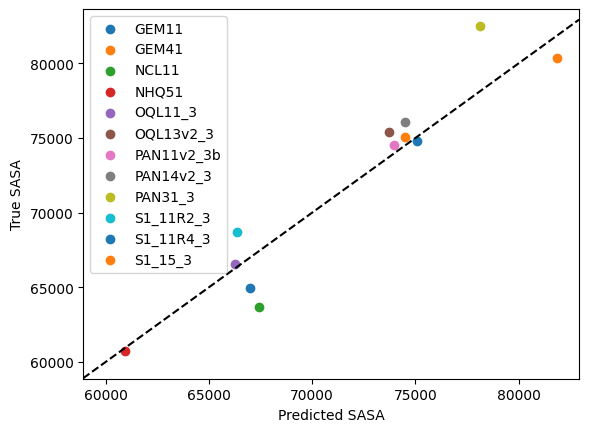

In [ ]:
plot_true_and_predicted_sasa(mbtr_model, sasa_model)